In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np

In [3]:
base_dir = '../logs/d=1/l=1/k=1/2023-02-24/'

In [4]:
big_index = []
for i in range(1,51):
    file = base_dir + 'expt_{:03d}/dt=0.01/D=1/trotter=False/shots=1000/fidelity_to_0_shots.csv'.format(i)
    df = pd.read_csv(file)
    f = df['Fidelity'].to_numpy()
    if any(np.where(f > 1.0)[0]):
        big_index.append(i)
print(big_index)

[40]


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

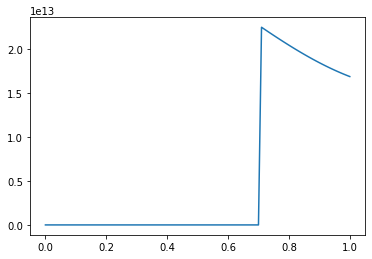

In [6]:
for i in big_index:
    file = base_dir + 'expt_{:03d}/dt=0.01/D=1/trotter=False/shots=1000/fidelity_to_0_shots.csv'.format(i)
    df = pd.read_csv(file)
    plt.plot(df['t'],df['Fidelity'])
    plt.show()

In [7]:
from random_hamiltonians import get_statevectors_from_csv

In [8]:
from hamiltonians import Hamiltonian, hm_list_from_csv

In [9]:
hm_list = hm_list_from_csv(base_dir + 'expt_040/ham.csv')
H = Hamiltonian(hm_list,1,1,None)
H.print()

New Term 0
Term 1 acting on the qubit locations [0]:
	(-0.07 + 0.18i) X_0 +
	(-0.59 + 0.51i) Y_0 +
	(-0.54 + 0.25i) Z_0 


In [10]:
from qnute_params import QNUTE_params as Params
from qnute_output import QNUTE_output as Output

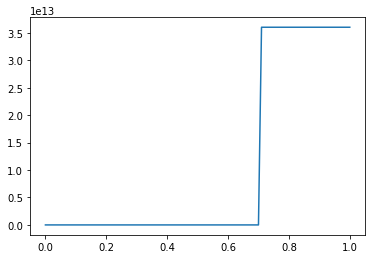

In [11]:
svs = get_statevectors_from_csv(base_dir + 'expt_{:03d}/dt=0.01/D=1/trotter=False/shots=1000/run_statevectors'.format(i))

norms = np.linalg.norm(svs,axis=1)
plt.plot(df['t'],norms)
plt.show()

In [417]:
from helpers import TOLERANCE
from helpers import exp_mat_psi, sigma_matrices, int_to_base

N=500
nnorms = 20
norms = np.linspace(20,30,nnorms)
nbits = [1,2,3,4]
nnbits = len(nbits)

vec_norms = np.zeros((N,nnorms, nnbits, 2))
for J in range(nnbits):
    bits = nbits[J]
    for I in range(N):
        psi = np.random.normal(0,1,2**bits).astype(complex)
        psi /= np.linalg.norm(psi)

    #     print('|psi>:\t\t', psi)
    #     print()
        a = np.random.normal(0,10,4**bits)
        c = np.linalg.norm(a)
    #     print('a_list:\t\t', a)
    #     print('c=||a_list||\t', c)

        A = np.zeros((2**bits,2**bits),dtype=complex)
        for i in range(4**bits):
            sigma_matrix = 1.0
            p_string = int_to_base(i,4,bits)
            for p in p_string:
                sigma_matrix = np.kron(sigma_matrices[p], sigma_matrix)
                
            A += a[i] * sigma_matrix
        A *= 1j
    #     print()
    #     print('Matrix iA:\n',A)
    #     print()

        for k in range(nnorms):
            norm = norms[k]
    #         print('\nRenormalize A to norm=', norm)
            a_mat = (norm/c)*A
        #     print(a_mat)
        #     print()
            phi0 = exp_mat_psi(a_mat,psi)
    #         print('\texp(iA)|psi> from Taylor series centered at 0:\n\t\t',phi0)
    #         print('\tlog l2-norm:\t', np.log10(np.linalg.norm(phi0)))
            vec_norms[I,k,J,0] = np.linalg.norm(phi0)


        #     chi = psi.copy()
        #     phi = psi.copy()
        #     i = 1
        #     mat = a_mat - 1j*norm*np.eye(2)
        #     while(np.linalg.norm(chi) > TOLERANCE):
        #         chi = (1/i) * (mat@chi)
        #         phi += chi
        #         i += 1
        #     phi = (np.exp(1j*norm)*np.eye(2)) @ phi
        #     print()
        #     print('\texp(iA)|psi> from Taylor series centered at icI:\n\t\t',phi)
        #     print('\tlog l2-norm:\t', np.log10(np.linalg.norm(phi)))

            mat = a_mat / norm
            chi = psi.copy()
            phi = psi.copy()
            i = 1
            while np.linalg.norm(chi) > TOLERANCE:
                chi = (norm/i) * (mat @ chi)
                phi += chi
                i += 1
    #         print()
    #         print('\texp(iA)|psi> from Taylor series with normaliziation:\n\t\t',phi)
    #         print('\tlog l2-norm:\t', np.log10(np.linalg.norm(phi)))
            vec_norms[I,k,J,1] = np.linalg.norm(phi)

        #     mat = a_mat / norm - 1j*np.eye(2)
        #     chi = psi.copy()
        #     phi = psi.copy()
        #     i = 1
        #     while np.linalg.norm(chi) > TOLERANCE:
        #         chi = (norm/i) * (mat @ chi)
        #         phi += chi
        #         i += 1
        #     print()
        #     print('\texp(iA)|psi> from Taylor series with normaliziation centered at icI:\n\t\t',phi)
        #     print('\tlog l2-norm:\t', np.log10(np.linalg.norm(phi)))

In [418]:
means = np.zeros((nnbits,2,nnorms))
stds = np.zeros((nnbits,2,nnorms))
for i in range(nnbits):
    for j in range(2):
        for k in range(nnorms):
            means[i,j,k] = np.mean(vec_norms[:,k,i,j])
            stds[i,j,k]  = np.std(vec_norms[:,k,i,j])

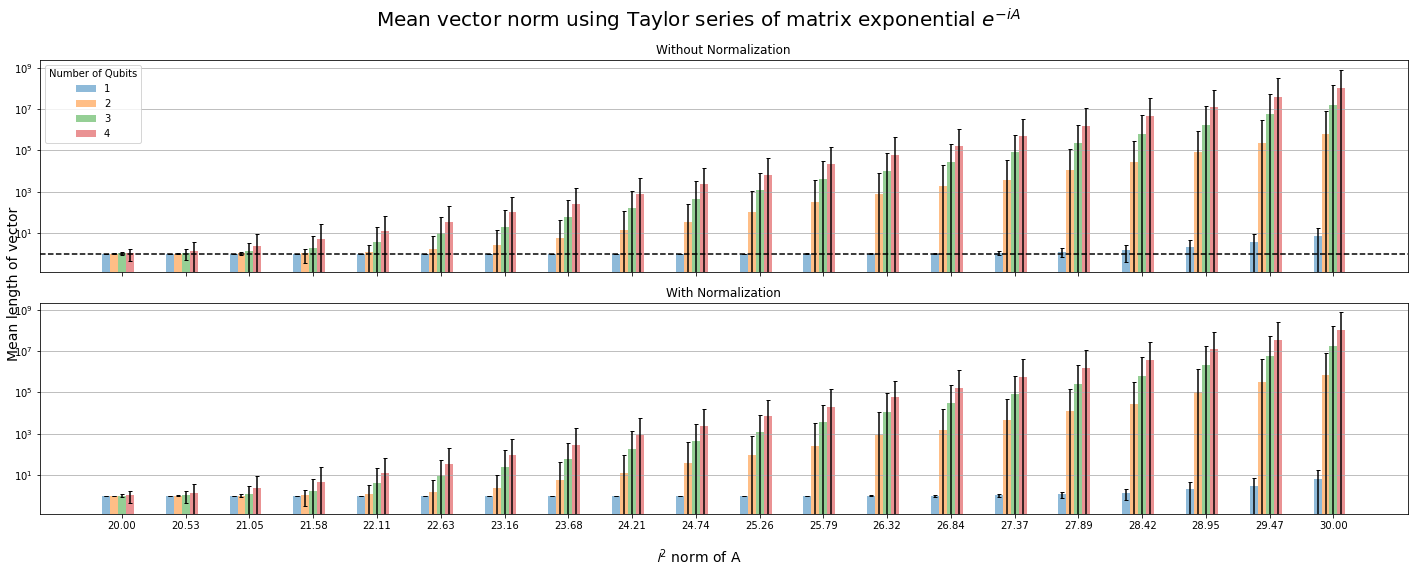

In [420]:
fig,axs = plt.subplots(2,1,figsize=(20,8),sharex=True,sharey=True)
width = 1/8
ax = axs[0]
for i in range(nnbits):
    offset = width*i
    xpoints = np.arange(nnorms)
    ax.bar(xpoints + offset, means[i,0,:], width, yerr=stds[i,0,:], alpha=0.5, capsize=2, label=nbits[i])
ax.set_xticks(xpoints+width*2)
ax.set_xticklabels([format(norm,'0.2f') for norm in norms])
ax.set_yscale('log')
ax.legend(title='Number of Qubits')
ax.yaxis.grid(True)
ax.set_title('Without Normalization')
ax.axhline(y=1.0,color='k',label='1.0', linestyle='--')

ax = axs[1]
for i in range(nnbits):
    offset = width*i
    xpoints = np.arange(nnorms)
    ax.bar(xpoints + offset, means[i,1,:], width, yerr=stds[i,1,:], alpha=0.5, capsize=2, label=nbits[i])
ax.set_xticks(xpoints+width*2)
ax.set_xticklabels([format(norm,'0.2f') for norm in norms])
ax.set_yscale('log')
ax.yaxis.grid(True)
ax.set_title('With Normalization')

fig.supxlabel('$\mathcal{l}^2$ norm of A',fontsize=14)
fig.supylabel('Mean length of vector', fontsize=14)
fig.suptitle('Mean vector norm using Taylor series of matrix exponential $e^{-iA}$',fontsize=20)
fig.tight_layout()
fig.set_facecolor('white')
plt.savefig('exp_iA_plots.png',dpi=300)
plt.show()

In [268]:
np.abs(-0.63095793+0.75586713j)**2

0.9694430276443219

In [269]:
np.abs(0.9840164 -0.0339815j)**2

0.9694430178112101

In [265]:
np.linalg.norm([-0.04280212-0.7873854j,  -0.0661611 -0.61140344j])

0.9999996236032781

In [12]:
from qnute import *

In [13]:
psi0 = svs[np.where(norms>1.0)[0][0]-1]
print(psi0)
psi0/=np.linalg.norm(psi0)
print(psi0)

[ 0.7844741 -0.27774059j -0.46381422-0.30386969j]
[ 0.78447415-0.27774061j -0.46381425-0.30386971j]


In [14]:
np.linalg.norm(psi0)

1.0

In [15]:
from qiskit.quantum_info import Statevector
Statevector(svs[71])

Statevector([-1.40354810e+13-3.13849572e+13j,
              3.49909469e+12-1.01601197e+13j],
            dims=(2,))


In [16]:
params = Params(H)
params.load_hamiltonian_params(1)
params.set_run_params(
    0.01,0.1,30,1000,None,init_sv=psi0
)

Performing Hamiltonian precalculations...
	Calculating Unitary Domains... Done
	Calculating Required Pauli Measurements... Done


In [39]:
import time
N=10

As = np.zeros((N,4))
exps = np.zeros((N,2,4))
_max = 1000
for k in range(N):
    t1 = time.time()
    out = qnute(params,log_to_console=False)
    total = 1
    while not any(np.where(np.linalg.norm(out.svs,axis=1)>1.1)[0]):
        out = qnute(params,log_to_console=False)
        total += 1
    t2 = time.time()
    print('{}. Time for {} iterations: {} seconds'.format(k+1, total, t2-t1))
#     if total > _max:
#         print('\tMiss')
#         continue
#     else:
    print('\tHit')
    norms = np.linalg.norm(out.svs,axis=1)
    I = np.where(norms > 1.0)[0][0] - 1
    As[k] = out.a_list[I][0]
    psi = out.svs[I]
    for i in range(4):
        exps[k][0][i] = out.exp[I]['S'][i]
        exps[k][1][i] = psi.conj().T @ sigma_matrices[i] @ psi

1. Time for 1019 iterations: 29.873518466949463 seconds
	Hit


C:\Users\CMP3KUMARS\AppData\Local\Temp\ipykernel_7804\1845779655.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  exps[k][1][i] = psi.conj().T @ sigma_matrices[i] @ psi


2. Time for 1082 iterations: 30.360316276550293 seconds
	Hit
3. Time for 1908 iterations: 53.03301286697388 seconds
	Hit
4. Time for 7321 iterations: 220.1260006427765 seconds
	Hit
5. Time for 419 iterations: 11.28191590309143 seconds
	Hit
6. Time for 9938 iterations: 286.47360920906067 seconds
	Hit
7. Time for 3852 iterations: 113.454350233078 seconds
	Hit
8. Time for 81 iterations: 2.3701422214508057 seconds
	Hit
9. Time for 1128 iterations: 32.93516564369202 seconds
	Hit
10. Time for 3611 iterations: 107.32757210731506 seconds
	Hit


In [40]:
As

array([[-3569.24352242, -1760.48128195, -3094.09943119,   265.60244977],
       [ 2391.57977154,  1152.86676474,  2085.61921211,  -195.43022926],
       [ 2422.60930974,  1486.29444435,  1692.67525219,  -890.05464179],
       [-3729.19710536, -1938.75607991, -3033.86471011,   973.62171569],
       [ 2485.7171389 ,  1340.35544492,  1954.63281126,  -747.59031587],
       [ 7295.97082421,  3446.85646221,  6364.11827635,  -916.76167703],
       [ 7333.70054692,  4330.82307885,  5139.74070162, -2932.95098321],
       [-7417.1385467 , -4181.39580096, -5383.54250496,  2924.9834352 ],
       [-7437.09695116, -4065.18176393, -5822.98632654,  2210.37715885],
       [-3711.10105014, -1971.76749998, -3005.01437389,   926.49387794]])

In [45]:
for i in range(N):
    print('Theoretical Expectations: {:+0.5f}, {:+0.5f}, {:+0.5f}'.format(exps[i][1][1], exps[i][1][2], exps[i][1][3]))
    print('Statistical Expectations: {:+0.5f}, {:+0.5f}, {:+0.5f}'.format(exps[i][0][1], exps[i][0][2], exps[i][0][3]))
    print('Differences             : {:+0.5f}, {:+0.5f}, {:+0.5f}'.format(np.abs(exps[i][1][1] - exps[i][0][1]), 
                                                                          np.abs(exps[i][1][2] - exps[i][0][2]), 
                                                                          np.abs(exps[i][1][3] - exps[i][0][3]) ))
    print()

Theoretical Expectations: -0.45509, -0.88926, +0.04596
Statistical Expectations: -0.51800, -0.91000, +0.07800
Differences             : +0.06291, +0.02074, +0.03204

Theoretical Expectations: -0.46792, -0.88028, +0.07848
Statistical Expectations: -0.50600, -0.91600, +0.08600
Differences             : +0.03808, +0.03572, +0.00752

Theoretical Expectations: -0.55748, -0.74292, +0.37051
Statistical Expectations: -0.64400, -0.73400, +0.38600
Differences             : +0.08652, +0.00892, +0.01549

Theoretical Expectations: -0.51382, -0.82610, +0.23139
Statistical Expectations: -0.54600, -0.85400, +0.27400
Differences             : +0.03218, +0.02790, +0.04261

Theoretical Expectations: -0.55251, -0.76771, +0.32458
Statistical Expectations: -0.56600, -0.82600, +0.31600
Differences             : +0.01349, +0.05829, +0.00858

Theoretical Expectations: -0.48795, -0.86647, +0.10553
Statistical Expectations: -0.49600, -0.91600, +0.13200
Differences             : +0.00805, +0.04953, +0.02647

Theo

In [59]:
for i in range(30):
    print(np.linalg.norm(out.a_list[i][0]))

1.0748180844055573
1.0014958865593468
0.963738951506626
0.9251142134210296
0.9260753390589276
0.9600599800412879
0.999533508259241
0.8899122099821223
0.9039258319253558
0.9204073489944019
1.1364700291831455
5248.679869400315
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436
0.30661259088598436


In [50]:
np.linalg.norm(10)

10.0

In [49]:
np.linalg.norm(As,axis=1)

array([ 5048.04809979,  3381.82732458,  3425.70486436,  5274.27345826,
        3514.94283319, 10317.67721664, 10371.03313089, 10489.8080566 ,
       10518.0345492 ,  5248.6798694 ])

In [59]:
norms = np.linalg.norm(out.svs,axis=1)
norms
I = np.where(norms > 1.0)[0][0] - 1
out.svs[I]

array([ 0.71728738-0.32130185j, -0.51985817-0.33468103j])

In [51]:
psi=out.svs[I]
exps = np.zeros(4)
for i in range(4):
    exps[i] = psi.conj().T @ sigma_matrices[i] @ psi
print(exps)

[ 0.99999999 -0.53070814 -0.81418776  0.23547215]


C:\Users\CMP3KUMARS\AppData\Local\Temp\ipykernel_9316\675223602.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  exps[i] = psi.conj().T @ sigma_matrices[i] @ psi


In [52]:
out.exp[I]

{'c': {}, 'S': {0: 1.0, 1: -0.604, 2: -0.8140000000000001, 3: 0.274}, 'b': {}}

In [53]:
print(out.a_list[I][0], out.S_list[I], out.b_list[I], out.c_list[I])

[2444.745418756535, 1406.7165102053461, 1894.4452426729981, -637.4479966934215] [[ 1.   +0.j    -0.604-0.j    -0.814-0.j     0.274-0.j   ]
 [-0.604+0.j     1.   +0.j     0.   +0.274j -0.   +0.814j]
 [-0.814+0.j     0.   -0.274j  1.   +0.j     0.   -0.604j]
 [ 0.274+0.j    -0.   -0.814j  0.   +0.604j  1.   +0.j   ]] [ 1.1734778   0.85220557 -1.71053212  1.07969642] 1.003737710955814


In [56]:
S = out.S_list[I]
a = out.a_list[I][0]
(2.0*np.real(S) + np.eye(4)*0.1) @ a

array([ 1.1734778 ,  0.85220557, -1.71053212,  1.07969642])

In [57]:
out.b_list[I]

array([ 1.1734778 ,  0.85220557, -1.71053212,  1.07969642])

In [48]:
for i in range(30):
    print(i,out.a_list[i][0])

0 [0.24864953195751335, 0.5615248638821815, -0.5971888635947864, 0.3769260382742182]
1 [0.6053517381871822, 0.7725596660393854, -0.362193082723782, 0.2631500710227042]
2 [1.4821989992422706, 1.2866559688633707, 0.23432068164542671, -0.0839523586909061]
3 [0.3625398055108395, 0.6170804872620118, -0.5377539513380941, 0.3761289765468184]
4 [0.2386029929382459, 0.5315148191491288, -0.6258776106832623, 0.4194666106992319]
5 [0.2880253013980695, 0.5583409937386185, -0.5760975736511635, 0.40172622658429225]
6 [0.1446585871816726, 0.4377552374963583, -0.6751809397863724, 0.4453278072768745]
7 [0.3350475025212491, 0.5947681115029998, -0.4950575827386246, 0.34160021714719246]
8 [0.36405117759035993, 0.6039147013596572, -0.5164335727944728, 0.38020228834116765]
9 [0.17748405502064574, 0.456181244575694, -0.6436968331812871, 0.43793686521703334]
10 [0.7192737563562825, 0.7832912552113883, -0.18039463633642017, 0.2391380001451728]
11 [0.272403254766318, 0.5335976914544389, -0.5613137312581281, 0.40

In [49]:
out.svs

array([[ 7.84474152e-01-2.77740611e-01j, -4.63814250e-01-3.03869706e-01j],
       [ 7.78220902e-01-2.81832320e-01j, -4.69659580e-01-3.07185040e-01j],
       [ 7.71656703e-01-2.86029631e-01j, -4.75716909e-01-3.10526011e-01j],
       [ 7.64737573e-01-2.89875346e-01j, -4.82509493e-01-3.13581422e-01j],
       [ 7.58024948e-01-2.94198857e-01j, -4.88363196e-01-3.16775294e-01j],
       [ 7.51308279e-01-2.98546371e-01j, -4.94086124e-01-3.19819986e-01j],
       [ 7.44577674e-01-3.02782143e-01j, -4.99708449e-01-3.22828925e-01j],
       [ 7.37967222e-01-3.07145136e-01j, -5.05073719e-01-3.25525373e-01j],
       [ 7.31418215e-01-3.10714890e-01j, -5.10526922e-01-3.28398992e-01j],
       [ 7.24447788e-01-3.14735941e-01j, -5.16121604e-01-3.31262982e-01j],
       [ 7.17641665e-01-3.18947792e-01j, -5.21342195e-01-3.33863811e-01j],
       [ 7.10998393e-01-3.22293712e-01j, -5.26751297e-01-3.36364534e-01j],
       [ 7.04044377e-01-3.26123097e-01j, -5.32021253e-01-3.38996468e-01j],
       [ 6.97068505e-01-3

In [50]:
from helpers import sigma_matrices, exp_mat_psi

In [51]:
phis = np.zeros((30,2),dtype=complex)
for i in range(30):
    psi = out.svs[i]
    A = np.zeros((2,2),dtype=complex)
    for j in range(4):
        A += out.a_list[i][0][j] * sigma_matrices[j]
    phis[i] = exp_mat_psi(-1j*params.dt*A,psi)

In [53]:
i=I
psi = out.svs[i]
A = np.zeros((2,2),dtype=complex)
for j in range(4):
    A += out.a_list[i][0][j] * sigma_matrices[j]
print(psi,np.linalg.norm(psi))
print(out.a_list[i][0])
print(A)
phi = exp_mat_psi(-1j*params.dt*A,psi)
print(phi,np.linalg.norm(phi))

[ 0.62646848-0.36763944j -0.58384629-0.36263199j] 0.9999999822742248
[-3540.0811977897242, -1732.619870706761, -3082.3075693290953, 182.517384458945]
[[-3357.56381333   +0.j         -1732.61987071+3082.30756933j]
 [-1732.61987071-3082.30756933j -3722.59858225   +0.j        ]]
[-3.10698353e+11+9.85354474e+11j  6.92637341e+11+4.71581158e+11j] 1330260192736.4465


In [55]:
out.a_list[I][0]

[-3540.0811977897242,
 -1732.619870706761,
 -3082.3075693290953,
 182.517384458945]

In [57]:
out.S_list[I]

array([[ 1.   +0.j   , -0.514-0.j   , -0.914-0.j   ,  0.054-0.j   ],
       [-0.514+0.j   ,  1.   +0.j   ,  0.   +0.054j, -0.   +0.914j],
       [-0.914+0.j   ,  0.   -0.054j,  1.   +0.j   ,  0.   -0.514j],
       [ 0.054+0.j   , -0.   -0.914j,  0.   +0.514j,  1.   +0.j   ]])

In [58]:
out.b_list[I]

array([ 1.13282598,  0.70174284, -1.57746603,  0.957738  ])

In [59]:
out.c_list[I]

1.0054500191947127

In [124]:
params.h_domains,params.u_domains,params.mix_domains

([[0]], [[0]], [[0]])

In [130]:
x =np.real(psi.conj().T @ sigma_matrices[1] @ psi)
y = np.real(psi.conj().T @ sigma_matrices[2] @ psi)
z = np.real(psi.conj().T @ sigma_matrices[3] @ psi)
print(x,y,z)
S = np.array([
    [1.0,    x   ,    y  , z],
    [x  ,  1.0   , 1.0j*z, -1.0j*y],
    [y  , -1.0j*z, 1.0   , 1.0j*x],
    [z  ,  1.0j*y, -1.0j*x, 1.0]
], dtype=complex)
print(S)
c = 1.0
i=0
for ex in [x,y,z]:
    c += 2*params.dt * np.real(H.hm_list[0][1][i]) * ex
    i += 1
c = np.sqrt(c)
print(c)
b = np.zeros(4,dtype=complex)
h_mat = H.get_matrix()
for k in range(4):
    b[k] = np.imag(psi.conj().T @ (sigma_matrices[k] @ h_mat) @ psi)
b = (-2.0/c) * b
print(b)

a = np.real(np.linalg.lstsq(2*np.real(S) + params.delta*np.eye(4), b, rcond=-1 )[0] )
print(a)

-0.541471731697525 -0.7980642988235821 0.26438933006793863
[[ 1.        +0.j         -0.54147173+0.j         -0.7980643 +0.j
   0.26438933+0.j        ]
 [-0.54147173+0.j          1.        +0.j          0.        +0.26438933j
   0.        +0.7980643j ]
 [-0.7980643 +0.j          0.        -0.26438933j  1.        +0.j
  -0.        -0.54147173j]
 [ 0.26438933+0.j         -0.        -0.7980643j   0.        +0.54147173j
   1.        +0.j        ]]
1.003650110463075
[ 1.13061963-0.j  0.8237083 -0.j -1.64134927+0.j  1.00886112-0.j]


In [110]:
chi = psi.copy()
phi = psi.copy()
i = 1
mat = -1j*params.dt*A
print(mat)
while np.linalg.norm(chi) > 1e-5:
    chi = 1/i * (mat@chi)
    print(i, chi, np.linalg.norm(chi))
    phi += chi
    i += 1

[[  0.        -18.07297422j -18.94445243-14.0671651j ]
 [ 18.94445243-14.0671651j    0.        -30.82193415j]]
1 [-0.58888657+0.1717452j  -0.64323385-0.47608316j] 1.008309857284286
2 [  4.29625964+14.35527167j -11.70698465+15.6816474j ] 24.647499396280352
3 [233.94039725 -70.01410893j 255.55565551+190.78282594j] 401.66760468477884
4 [-855.7379082 -2859.30463435j 2331.81709891-3123.49418373j] 4909.327576986931
5 [-27957.96908434 +8367.31200104j -30541.18570463-22800.25345267j] 48002.869989136954
6 [  68178.88734011+227808.31218223j -185781.99441855+248856.98765986j] 391139.02584058495
7 [1591060.60579014 -476175.52122801j 1738068.93062125+1297540.0667032j ] 2731796.260815418
8 [-2909995.21816722 -9723260.74789255j  7929503.34731446-10621655.35916127j] 16694503.81548175
9 [-52818324.37359602+15807564.49343224j
 -57698549.14837301-43074344.1710897j ] 90687243.78017634
10 [ 7.72823214e+07+2.58225910e+08j -2.10588121e+08+2.82085063e+08j] 443364992.92279375
11 [1.14768400e+09-3.43480962e+08j

In [99]:
phis

array([[   0.77799503-2.82431503e-01j,   -0.46971321-3.07124849e-01j],
       [   0.77155794-2.86809511e-01j,   -0.47555834-3.10294882e-01j],
       [   0.76510634-2.90803217e-01j,   -0.48140285-3.13523652e-01j],
       [   0.75856649-2.95028805e-01j,   -0.48713948-3.16591219e-01j],
       [   0.75179835-2.99053676e-01j,   -0.49311891-3.19687146e-01j],
       [   0.74509978-3.03117086e-01j,   -0.49879304-3.22725658e-01j],
       [   0.73833236-3.07068417e-01j,   -0.50446741-3.25709892e-01j],
       [   0.73160726-3.11360686e-01j,   -0.50983545-3.28440472e-01j],
       [ -28.27135534-2.34375819e+02j, -100.70516866+5.79463848e+02j],
       [ -28.53103003-2.34309419e+02j,  -98.7408324 +5.79815919e+02j],
       [ -28.79042146-2.34240762e+02j,  -96.77548885+5.80162096e+02j],
       [ -29.04952669-2.34169849e+02j,  -94.80915781+5.80502374e+02j],
       [ -29.30834275-2.34096681e+02j,  -92.84185908+5.80836750e+02j],
       [ -29.56686669-2.34021257e+02j,  -90.8736125 +5.81165221e+02j],
      